# Домашнее задание 5
**Выполнил: Ким Адамейко, группа мАДБМ16**

In [263]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import pubchempy as pcp
import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole 
from __future__ import print_function, division

from IPython.display import display,Image, Markdown

import os
curdir = os.getcwd()
! export PATH=${PATH}:/{curdir}

def show_compound_3d(smiles, view, grid=(0, 0)):
    m2d = Chem.MolFromSmiles(smiles)
    m3d = Chem.AddHs(m2d)
    Chem.AllChem.EmbedMolecule(m3d)
    AllChem.MMFFOptimizeMolecule(m3d,maxIters=500,nonBondedThresh=200 )
    mb = Chem.MolToMolBlock(m3d)
    view.addModel(mb,'sdf', viewer=grid)
    view.setStyle({'model':0},{'stick': {}}, viewer=grid)
    view.zoomTo(viewer=grid)
    return view

Будем работать с этаном:

In [264]:
view = py3Dmol.view(width=300, height=300)
show_compound_3d('CC', view)

## Часть 1. Зависимость энергии молекулы от длины связи C−C

Загрузим оптимизированную структуру этана в виде z-matrix :

In [ ]:
inp_init = '''!HF RHF 6-31G
* int 0 1
C 0 0 0 0 0 0 
C 1 0 0 1.52986 0 0 
H 1 2 0 1.08439 111.200 0
H 1 2 3 1.08439 111.200 120
H 1 2 3 1.08439 111.200 -120
H 2 1 3 1.08439 111.200 180
H 2 1 6 1.08439 111.200 120
H 2 1 6 1.08439 111.200 -120
*
'''

Цель: рассчитать 20 разных длин связи с шагом 0.02 Å для расчёта энергии в ORCA с разными значениями по длине одной из связей ($\text{C-C}$). Сделаем на основе данной нам матрицы генератор подобных ей:

In [30]:
def gen_zmatrix(**kwargs):
    return '''!HF RHF 6-31G
    * int 0 1
    C 0 0 0 0 0 0 
    C 1 0 0 {blength} 0 0 
    H 1 2 0 1.08439 {hcc_angle} 0
    H 1 2 3 1.08439 {hcc_angle} 120
    H 1 2 3 1.08439 {hcc_angle} -120
    H 2 1 3 1.08439 {hcc_angle} {tor1}
    H 2 1 5 1.08439 {hcc_angle} {tor2}
    H 2 1 5 1.08439 {hcc_angle} {tor3}
    *
    '''.format(**kwargs)

In [132]:
bl_step = 0.02
bl0 = 1.52986
tor = 180
params1 = {'hcc_angle': 111.200, 'tor1': tor, 'tor2': tor-60, 'tor3': tor+60}
blengths = np.linspace(bl0 - bl_step*10, bl0 + bl_step*10, 21)

In [133]:
dir1 = './task1/'
! mkdir -p {dir1}
energy_values1 = []
for bl in blengths:
    z = gen_zmatrix(blength = bl, **params1)
    ! echo '{z}' > {dir1}{bl}.zm
    ! orca {dir1}{bl}.zm > {dir1}{bl}.out 2>{dir1}{bl}.err
    res = ! grep 'FINAL SINGLE POINT ENERGY' {dir1}{bl}.out
    energy_values1.append(float(res[0].split(' ')[-1]))

Изобразим полученные точки на графике, чтобы "прикинуть" начальные значения коэффициентов (т.к. оптимизируем численно итерационно):

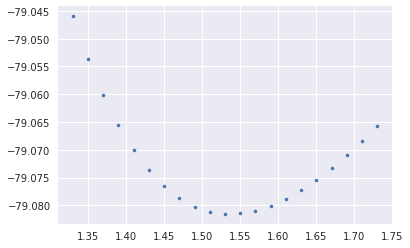

In [162]:
plt.plot(blengths, energy_values1, ".")
plt.show()

Подготовим функцию для построения приближённой модели и вывода информации о ней и графика

In [153]:
# Параметры: координаты точек, модель, начальные параметры модели
def fit_and_plot(xs, ys, fitfunc, init_coef):
    
    # Минимизируем функцию ошибки
    errfunc = lambda coef, x, y: fitfunc(coef, x) - y          
    coef, _ = optimize.leastsq(errfunc, init_coef[:], args=(xs, ys))
    plt.plot(xs, ys, ".", xs, fitfunc(coef, xs), "-")
    plt.show()
    print('Mean Square Error = %.3g' % np.square(ys - fitfunc(coef, xs)).mean())
    return coef.tolist()

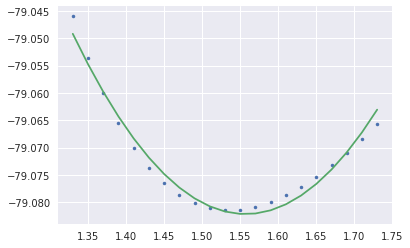

Mean Square Error = 2.13e-06


Fitted function: $f(x) = -79.082 + 0.640(x-1.557)^2$

In [154]:
coef1 = fit_and_plot(blengths, energy_values1, lambda c, x: c[0]*(x-c[1])**2 + c[2], [1, 1, -79]) 
display(Markdown(r"Fitted function: $f(x) = {2:.3f} + {0:.3f}(x-{1:.3f})^2$".format(*coef1)))

В статье [1] находим формулу (1)
$$E_{\text{pair}} = \sum\limits_\text{bonds} k_r (r-r_{eq})^2 
+ \sum\limits_\text{angles} k_\theta (\theta - \theta_{eq})^2 
+ \sum\limits_\text{dihedrals} \dfrac{v_n}{2}\left(1 + \cos (n \varphi - \gamma)\right) 
+ \sum\limits_{i<j}\left(
    \dfrac{A_{ij}}{R_{ij}^{12}} 
    - \dfrac{B_{ij}}{R_{ij}^6}
    +\dfrac{q_i\,q_j}{\varepsilon\,R_{ij}}\right),$$ 

где выражения с нижним индексом $_{eq}$ соответствуют параметрам структуры в равновесном состоянии, $k_r,\ k_\theta, v_n$ - искомые константы взаимодействия; $n, \gamma - $ кратность и фазовый угол торсионных углов. Параметры $A, B, q$ характеризуют потенциалы нековалентных взаимодействий. 
    
В нашем случае моделировалось только изменение длины связи, поэтому все суммы кроме первой полагаем равными нулю.   Тогда $E = K_r (r-r_{eq})^2$, откуда $K_r = \dfrac{E}{(r-r_{eq})^2}$. Т.е. константа ковалентного взаимодействия, согласно нашей модели, равна $0.64 \dfrac{\text{Ha}}{Å^2}$, поскольку ORCA выдаёт значение энергии в атомных единицах энергии Хартри. 

Энергия Хартри равна абсолютному значению электрической потенциальной энергии атома водорода в основном состоянии [2]. При этом $1\ \text{Ha} =	627.509\ \text{ккал/моль}$. Можно перевести энергию в Ккал/моль:

$E = 0.64 * 627.509 = 401.605\ \dfrac{\text{ккал}}{\text{моль}\cdot Å^2}$

В статье при этом для длины связи $\text{C-C}$ использовалась линейная регрессия с двойными логарифмическими координатами (см. рис. 2 в [1]), в результате которой с коэффициентом детерминации $R^2 = 0.987$ получена следующая модель: 

$$\log k_r = -4.9575 \log r + 7.8187,$$

Подставим значения для равновесного состояния $(r = 1.52986):$

In [118]:
np.exp(-4.9575 * np.log(bl0) + 7.8187)

302.13950564613629

Итак, в статье на основе методов молекулярной динамики, получена константа $302.1\ \dfrac{\text{ккал}}{\text{моль}\cdot Å^2}, $ расчёты же, выполненные в ORCA методами квантовой химии, дали результат $401.6\ \dfrac{\text{ккал}}{\text{моль}\cdot Å^2}.$ Константы получились одного порядка, хотя и довольно сильно отличающиеся.

## Часть 2. Зависимость энергии молекулы от валентного угла HCС

In [127]:
hcc_step = 0.2
hcc0 = 111.2
tor = 180
params2 = {'blength': 1.52986, 'tor1': tor, 'tor2': tor-60, 'tor3': tor+60}
hcc_angles = np.linspace(hcc0 - hcc_step*10, hcc0 + hcc_step*10, 21)

In [168]:
dir2 = './task2/'
! mkdir -p {dir2}
energy_values2 = []
for hcc_angle in hcc_angles:
    z = gen_zmatrix(hcc_angle = hcc_angle, **params2)
    ! echo '{z}' > {dir2}{bl}.zm
    ! orca {dir2}{bl}.zm > {dir2}{bl}.out 2>{dir2}{bl}.err
    res = ! grep 'FINAL SINGLE POINT ENERGY' {dir2}{bl}.out
    energy_values2.append(float(res[0].split(' ')[-1]))

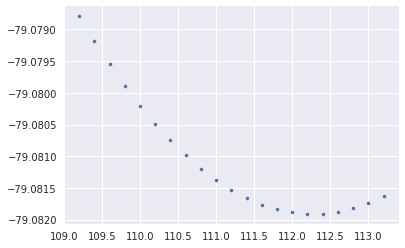

In [169]:
plt.plot(hcc_angles, energy_values2, ".")
plt.show()

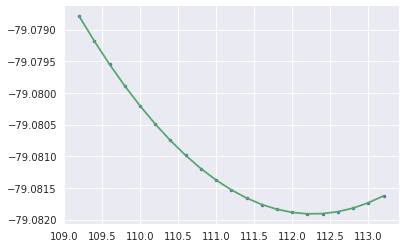

Mean Square Error = 1.09e-12


Fitted function: $f(x) = -79.082 + 0.00033(x-112.271)^2$

In [170]:
coef2 = fit_and_plot(hcc_angles, energy_values2, lambda c, x: c[0]*(x-c[1])**2 + c[2], [1, 112, -79]) 
display(Markdown(r"Fitted function: $f(x) = {2:.3f} + {0:.5f}(x-{1:.3f})^2$".format(*coef2)))

Производя аналогичные предыдущему пункту преобразования, получим, что $K_\theta = \dfrac{E}{(\theta-\theta_{eq})^2}, $ откуда $K_\theta = 0.00033 \dfrac{\text{Ha}}{\text{моль}\cdot \text{град}^2}$

Или же, с учётом того, что в ORCA мы делали расчёт в градусах $(1\ \text{град} = 0.01745\ \text{рад})$ и единицах Хартри, считает в $K_\theta = 0.00033 \cdot 627.509 \cdot 0.01745^{-2} = 679.79 \dfrac{\text{ккал}}{\text{моль}\cdot \text{рад}^2}$

In [185]:
0.00033  * 627.509 * 0.0174533**-2

679.7962921751005

Уравнение для константы взаимодействия из молекулярной механики (формулы 5, 6 в статье):
$$
K^\theta_{ijk} = 143.9\  Z_iC_jZ_k\left(r_{ij}^{eq}+r_{jk}^{eq}\right)^{-1}\cdot\left(\theta_{ijk}^{eq}\right)^{-2}exp\left\{
{-2}\cdot\left(\frac{r_{ij}^{eq}-r_{jk}^{eq}}{r_{ij}^{eq}+r_{jk}^{eq}}\right)^2\right\} 
,$$
где $i, j, k - $ это атомы С-С-H.
Параметры для этого уравнения были взяты из таблицы 4 в статье. 

In [190]:
r_ij = bl0
r_jk = 1.08439
Cj = 1.339 
Zi = Zk = 1.183
grad2rad = 0.0174533
143.9 * Zi * Cj * Zk * (r_ij + r_jk)**-1 * (hcc0*grad2rad)**-2 * np.exp(-2 * ((r_ij - r_jk)/(r_ij + r_jk))**2)

25.839158719514142

После подстановки их в уравнение получили значение $K^\theta_{i\,j\,k} = 25.8\ \dfrac{\text{ккал}}{\text{моль}\cdot \text{рад}^2}$

В итоге получили значения, отличающиеся на порядок... Если я не допустил нигде ошибки в расчётах, это означает, что квантовые и неквантовые методы действительно могут давать сильно различающиеся результаты. Неквантовые методы хороши для больших молекул, например, сложных белков. Они в этом случае работают быстрее квантовых, и при этом дают приемлемую точность. Здесь же, на малой молекуле, мы видим заметные отличия в результатах.

## Часть 3. Зависимость энергии молекулы от торсионного угла связи C−С

In [197]:
tor_step = 12
tor0 = 0
params3 = {'blength': 1.52986, 'hcc_angle': 111.200}
torsions = np.linspace(tor0 - tor_step*15, tor0 + tor_step*15, 31)

In [198]:
dir3 = './task3/'
! mkdir -p {dir3}
energy_values3 = []
for tor in torsions:
    z = gen_zmatrix(tor1 = tor, tor2 = tor-60, tor3 = tor+60, **params3)
    ! echo '{z}' > {dir3}{bl}.zm
    ! orca {dir3}{bl}.zm > {dir3}{bl}.out 2>{dir3}{bl}.err
    res = ! grep 'FINAL SINGLE POINT ENERGY' {dir3}{bl}.out
    energy_values3.append(float(res[0].split(' ')[-1]))

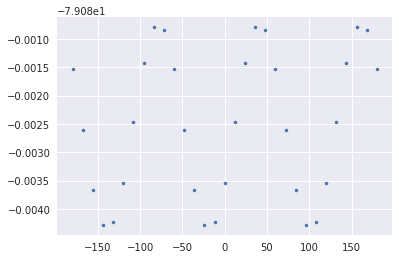

In [199]:
plt.plot(torsions, energy_values3, ".")
plt.show()

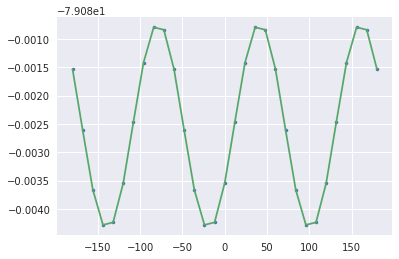

Mean Square Error = 5.71e-12


Fitted function: $f(x) = -79.081 + \dfrac{-0.00362}{2} \cdot (1 + \cos(0.995x - 0.982))$

In [222]:
coef3 = fit_and_plot(torsions, energy_values3, 
                     lambda c, x: c[0]/2 * (1 + np.cos(c[1]*x - c[2])) + c[3], [1, 1, 1, -79]) 
display(Markdown(r"Fitted function: $f(x) = {3:.3f} + \dfrac{{{0:.5f}}}{{2}} \cdot (1 + \cos({1:.3f}x - {2:.3f}))$"
                 .format(*coef3)))

Примечание. Форма моделируемой функции на основе формулы из статьи $E = \sum\limits_\text{dihedrals} \dfrac{v_n}{2}\left(1 + \cos (n \varphi - \gamma)\right) $.

Видим на графике **три точки локального минимума**.

## Часть 4. Зависимость энергии молекулы от длины связи C−C с шагом 0.1 Å

In [227]:
bl_step1 = 0.1
bl01 = 1.52986
tor = 180
params4 = {'hcc_angle': 111.200, 'tor1': tor, 'tor2': tor-60, 'tor3': tor+60}
blengths1 = np.linspace(bl01 - bl_step1*10, bl01 + bl_step1*10, 21)

In [230]:
dir4 = './task4/'
! mkdir -p {dir4}
energy_values4 = []
for bl in blengths1:
    z = gen_zmatrix(blength = bl, **params4)
    ! echo '{z}' > {dir4}{bl}.zm
    ! orca {dir4}{bl}.zm > {dir4}{bl}.out 2>{dir4}{bl}.err
    res = ! grep 'FINAL SINGLE POINT ENERGY' {dir4}{bl}.out
    energy_values4.append(float(res[0].split(' ')[-1]))

In [229]:
blengths1

array([ 0.52986,  0.62986,  0.72986,  0.82986,  0.92986,  1.02986,
        1.12986,  1.22986,  1.32986,  1.42986,  1.52986,  1.62986,
        1.72986,  1.82986,  1.92986,  2.02986,  2.12986,  2.22986,
        2.32986,  2.42986,  2.52986])

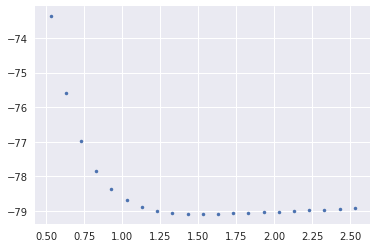

In [231]:
plt.plot(blengths1, energy_values4, ".")
plt.show()

Теперь это похоже на экспоненциальную зависимость. Это логично, поскольку приближая атомы, мы в какой-то момент получаем очень сильные взаимодействия. Попробуем смоделировать:

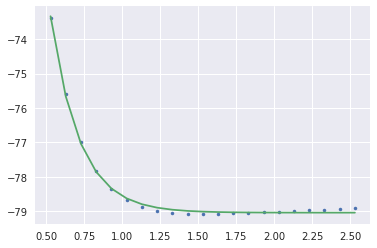

Mean Square Error = 0.00431


Fitted function: $f(x) = -79.045 + 4.30784\cdot exp\{{-5.243x+ 3.060}\}$

In [262]:
coef4 = fit_and_plot(blengths1, energy_values4, 
                     lambda c, x: c[0]*(np.exp(c[1]*x + c[2])) + c[3], [1, -1, 1, -79]) 
display(Markdown(r"Fitted function: $f(x) = {3:.3f} + {0:.5f}\cdot exp\{{{{{1:.3f}x+ {2:.3f}}}\}}$"
                 .format(*coef4)))

## Источники

1. [*Wanf, Wolf et al.* Development and Testing of a General Amber Force Field (PDF)](http://ambermd.org/antechamber/gaff.pdf)
1. [Hartree -- Wikipedia](https://en.wikipedia.org/wiki/Hartree)
1. [Z-matrix -- Wikipedia](https://en.wikipedia.org/wiki/Z-matrix_(chemistry%29)